# Atlas Based Segmentation

In [4]:
from os import listdir
from os.path import isdir, join
import os
import numpy as np
import nibabel as nib
import matplotlib.pyplot as plt
%matplotlib inline

In [1]:
# Normalize array from 0 to 1
def normalize(target_array):
    target_array -= target_array.min()
    normalized_array = np.divide(target_array, target_array.max())
    return normalized_array

# Read nii from path and normalize array from 0 to 1
def read_im(image_path):
    nii_img = nib.load(image_path)
    nii_data = nii_img.get_data()
    nii_data = normalize(nii_data)
    return nii_data, nii_img

def calc_dice(segmented_images, groundtruth_images):
    segData = segmented_images + groundtruth_images
    TP_value = np.amax(segmented_images) + np.amax(groundtruth_images)
    TP = (segData == TP_value).sum()  # found a true positive: segmentation result and groundtruth match(both are positive)
    segData_FP = 2. * segmented_images + groundtruth_images
    segData_FN = segmented_images + 2. * groundtruth_images
    FP = (segData_FP == 2 * np.amax(segmented_images)).sum() # found a false positive: segmentation result and groundtruth mismatch
    FN = (segData_FN == 2 * np.amax(groundtruth_images)).sum() # found a false negative: segmentation result and groundtruth mismatch
    return 2*TP/(2*TP+FP+FN)  # according to the definition of DICE similarity score

def dice_similarity(segmented_img, groundtruth_img):
    """
    Extract binary label images for regions  1) CSF (darkest) 3) GM (middle) 2) WM (light)
        Inputs: segmented_img (nibabel): segmented labels nii file
                groundtruth_img (nibabel): groundtruth labels nii file
        Returns: DICE_index (float): Dice similarity score between the two images (nii files)        
    """
    
    CSF_label = 1
    GM_label = 3
    WM_label = 2
    
    segmented_data = segmented_img.get_data().copy()
    groundtruth_data = groundtruth_img.get_data().copy()
    seg_CSF = (segmented_data == CSF_label) * 1
    gt_CSF = (groundtruth_data == CSF_label) * 1
    seg_GM = (segmented_data == GM_label) * 1
    gt_GM = (groundtruth_data == GM_label) * 1
    seg_WM = (segmented_data == WM_label) * 1
    gt_WM = (groundtruth_data == WM_label) * 1
    
    dice_CSF = calc_dice(seg_CSF, gt_CSF)
    dice_GM = calc_dice(seg_GM, gt_GM)
    dice_WM = calc_dice(seg_WM, gt_WM)
    
    
    return dice_CSF, dice_GM, dice_WM

def show_slice(img, slice_no):
    """
        Inputs: img (nibabel): image name
                slice_no (np slice): np.s_[:, :, 30]
        """
    data = img.get_fdata()
    plt.figure()
    plt.imshow(data[slice_no].T, cmap='gray')
    plt.show()

In [5]:
# Path to template image
mean_im = './our_atlas/mean_im.nii'
# Path to atlases 
GM_probs = './our_atlas/GM_probs.nii'
WM_probs = './our_atlas/WM_probs.nii'
CSF_probs = './our_atlas/CSF_probs.nii'

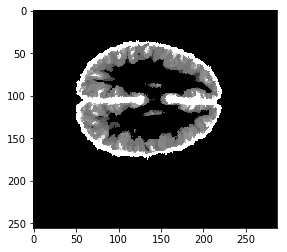

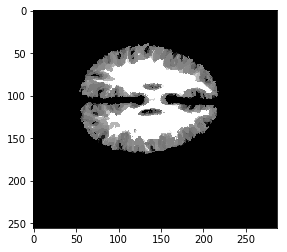

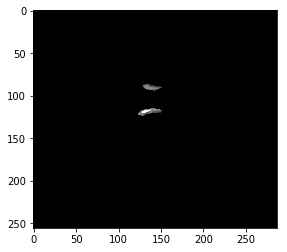

In [6]:
GM_atlas, _ = read_im(GM_probs)
WM_atlas, _ = read_im(WM_probs)
CSF_atlas, _ = read_im(CSF_probs)

plt.imshow(GM_atlas[:,:,150], cmap = "gray")
plt.show()
plt.imshow(WM_atlas[:,:,150], cmap = "gray")
plt.show()
plt.imshow(CSF_atlas[:,:,150], cmap = "gray")
plt.show()

# Segment an image using Atlas

In [8]:
# Path to test image
test_im = "./test-set/registration-results/our_templates/1003/result.1.nii"
test_data, test_im = read_im(test_im)

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in true_divide
  after removing the cwd from sys.path.


In [9]:
# Key the labels already in the files??????? are these the right labels??? which does he want???
CSF_label = 1
GM_label = 3
WM_label = 2

In [10]:
# Assign GM, WM, CSF to voxel with highest probability
GM = GM_label * np.nan_to_num((GM_atlas > CSF_atlas) * (GM_atlas > WM_atlas))
WM = WM_label * np.nan_to_num((WM_atlas > CSF_atlas) * (WM_atlas > GM_atlas))
CSF = CSF_label * np.nan_to_num((CSF_atlas > WM_atlas) * (CSF_atlas > GM_atlas))
seg_im = GM + WM + CSF

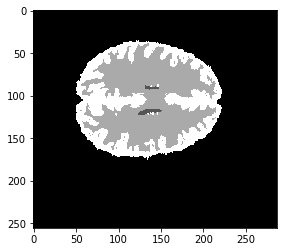

In [11]:
plt.imshow(seg_im[:,:,150], cmap = "gray")
plt.show()

# Segment All Images Using Atlas Only

In [12]:
# Path to test image folder
template_path = "./test-set/registration-results/our_templates/"
atlas_path = "./test-set/registration-results/our_atlases/"
result_path = "./test-set/segmentation-results/our-atlas-segmentation/"
gt_path = "./test-set/testing-labels/"

onlydirs = [f for f in listdir(template_path) if isdir(join(template_path, f))]

all_dice = np.zeros((len(onlydirs),3))
# Key the labels already in the files??????? are these the right labels??? which does he want???
CSF_label = 1
GM_label = 3
WM_label = 2

for i, f in enumerate(onlydirs):
    _, template_img = read_im(join(template_path,f,'result.1.nii'))
    GM_atlas, _ = read_im(join(atlas_path, f,'gm','result.nii.gz'))
    WM_atlas, _ = read_im(join(atlas_path, f,'wm','result.nii.gz'))
    CSF_atlas, _ = read_im(join(atlas_path, f,'csf','result.nii.gz'))

    # Assign GM, WM, CSF to voxel with highest probability
    GM = GM_label * np.nan_to_num((GM_atlas > CSF_atlas) * (GM_atlas > WM_atlas))
    WM = WM_label * np.nan_to_num((WM_atlas > CSF_atlas) * (WM_atlas > GM_atlas))
    CSF = CSF_label * np.nan_to_num((CSF_atlas > WM_atlas) * (CSF_atlas > GM_atlas))
    seg_im = GM + WM + CSF
    segmented_img = nib.Nifti1Image(seg_im, template_img.affine, template_img.header)

    # Calculate DICE
    path_gt = join(gt_path,f+"_3C.nii.gz")
    _, groundtruth_img = read_im(path_gt)
    all_dice[i,0], all_dice[i,1], all_dice[i,2] = dice_similarity(segmented_img, groundtruth_img)

    # Make directory to save result seg
    new_dir = join(result_path,f)
    #os.mkdir(new_dir)
    #nib.save(segmented_img, join(new_dir,'atlas_seg.nii.gz'))

print(all_dice)

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in true_divide
  after removing the cwd from sys.path.


[[0.78857968 0.68868545 0.71057832]
 [0.61626959 0.72282139 0.7502752 ]
 [0.75255727 0.73093797 0.75141595]
 [0.38478762 0.74658099 0.69080877]
 [0.8293793  0.73176029 0.75665095]
 [0.772837   0.69157754 0.74734099]
 [0.80428202 0.75088202 0.74230028]
 [0.76143395 0.75493329 0.76147781]
 [0.66753485 0.69995066 0.72786773]
 [0.77161225 0.73392829 0.75228366]
 [0.69293631 0.69341272 0.72994351]
 [0.77508074 0.72470715 0.75154439]
 [0.75205621 0.68652884 0.72460671]
 [0.76008366 0.71353487 0.74174338]
 [0.46904855 0.72411837 0.68491831]
 [0.80404666 0.72556466 0.73261001]
 [0.78333865 0.74150277 0.73969548]
 [0.77205362 0.70726452 0.70759131]
 [0.73314674 0.7544295  0.74969971]
 [0.61889307 0.72983527 0.74644191]]


In [28]:
# Save DICE values
with open('our_atlas_dice.csv', 'w+') as out_f:
    out_f.write('img,csf,gm,wm,\n')
    for index, row in enumerate(all_dice): 
        out_f.write(onlydirs[index] + ',' + ','.join(str(j) for j in row) + ',\n')

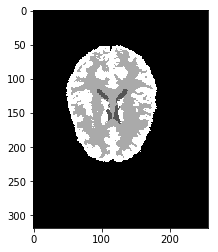

In [14]:
show_slice(segmented_img, np.s_[:, :, 150])